# Predicción de demanda en E-Commerce


## Objetivos del Proyecto

El principal objetivo de este proyecto es desarrollar un modelo de **machine learning** capaz de predecir si la demanda de un producto será **alta o baja**, utilizando un conjunto de datos sintéticos que incluye variables relacionadas con ventas, inventario, promociones y factores externos.      
Para que el modelo sea considerado satisfactorio, deberá cumplir con ciertos umbrales de desempeño en métricas clave. En particular, se espera que el modelo alcance un **F1-score mínimo de 0.75**, lo que garantiza un buen equilibrio entre precisión y recall en contextos con clases desbalanceadas. A sí mismo, se establece como meta alcanzar un **AUC-ROC superior a 0.85**, que refleje una alta capacidad del modelo para diferenciar entre los distintos niveles de demanda. Estos objetivos aseguran que el modelo sea aplicable a escenarios reales.



### Diccionario de Datos
* `Price`: Precio del producto, en un rango de 5 a 100 unidades.
* `Discount`: Característica binaria que indica si se aplicó un descuento (0 = no, 1 = sí).
* `Time_of_Day`: Característica categórica que representa el momento del día (0 = mañana, 1 = tarde, 2 = noche).
* `Day_of_Week`: Día de la semana (0 = lunes, 6 = domingo).
* `Stock_Level`: Número de artículos disponibles en inventario, entre 1 y 500.
* `Previous_Day_Sales`: Volumen de ventas del producto en el día anterior, en un rango de 10 a 200 unidades.
* `Promotion`: Característica binaria que indica si el producto estaba en promoción (0 = no, 1 = sí).
* `Weather`: Condición climática que afecta las ventas (0 = mala, 1 = buena).
* `Week_of_Year`: Número de semana en el año (1 a 52).
* `Product_Category`: Categoría del producto (seleccionada aleatoriamente entre 5 categorías).
* `Target`: Variable objetivo binaria que indica si la demanda fue alta (1) o baja (0).

# 1. Librerias 

In [182]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 2. Carga y Preparación de Datos

In [183]:
# Carga de datos
data = pd.read_csv('ecommerce_dataset.csv')    

In [184]:
# Imprimir muesta aleatoria del DataFrame
data.sample(10)

,Price,Discount,Time_of_Day,Day_of_Week,Stock_Level,Previous_Day_Sales,Promotion,Weather,Week_of_Year,Product_Category,Target
1532,0.808008,0.0,1.0,0.333333,0.345382,0.423280,0.0,0.0,0.901961,0.75,0
1743,0.270352,1.0,1.0,0.000000,0.789157,0.380952,0.0,1.0,0.705882,0.75,0
247,0.824718,1.0,0.0,1.000000,0.381526,0.000000,0.0,1.0,0.607843,0.25,0
1057,0.020492,0.0,0.0,1.000000,0.961847,0.968254,1.0,1.0,0.411765,0.75,0
1403,0.236386,0.0,0.5,1.000000,0.730924,0.724868,0.0,1.0,0.117647,0.00,0
467,0.575312,1.0,1.0,0.000000,0.875502,0.555556,0.0,1.0,0.333333,0.75,0
1056,0.768696,0.0,0.5,1.000000,0.753012,0.386243,0.0,1.0,0.882353,0.50,0
1443,0.560019,0.0,0.5,0.833333,0.578313,0.619048,1.0,1.0,0.921569,0.50,0
1038,0.381952,1.0,0.5,0.333333,0.640562,0.153439,0.0,1.0,0.490196,0.50,0
17,0.003747,1.0,0.0,0.833333,0.630522,0.671958,0.0,1.0,0.725490,0.25,0


El DataFrame parece estar limpo, se hará una revisión inicial para verificar la calidad. Primero, se convierten los nombres al formato adecuado `snake_case`utilizado en python, en este caso, los nombres de las columnas tiene que estar en minúsculas.

In [185]:
# Convertir nombres de columnas a snake_case
data.columns = [col.lower() for col in data.columns]

In [186]:
# Imprimir información general
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               2000 non-null   float64
 1   discount            2000 non-null   float64
 2   time_of_day         2000 non-null   float64
 3   day_of_week         2000 non-null   float64
 4   stock_level         2000 non-null   float64
 5   previous_day_sales  2000 non-null   float64
 6   promotion           2000 non-null   float64
 7   weather             2000 non-null   float64
 8   week_of_year        2000 non-null   float64
 9   product_category    2000 non-null   float64
 10  target              2000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 172.0 KB


**Análisis inicial del dataset**

El **shape** del dataset es `(2000, 11)`.      
Todas las columnas son **numéricas**: 10 de tipo `float64` y 1 de tipo `int64`.    
No hay valores nulos; el dataset está completo, pero es importante revisar la calidad de los datos.      

**Variables relevantes:**    
La columna`target` es la variable objetivo (clasificación o regresión).      
Variables predictoras incluyen: `price`, `discount`, `time_of_day`, `day_of_week`, `stock_level`,  
    `previous_day_sales`, `promotion`, `weather`, `week_of_year`, `product_category`.      
Algunas variables representan características temporales:`time_of_day`, `day_of_week`, `week_of_year`.        
Variables como `promotion`, `discount`, `stock_level` y `weather` pueden tener un impacto significativo en las ventas (`target`).       
La columna `product_category` está en formato numérico, como son datos sinteticos, no podemos encontrar el nombre real de la categoria.

In [187]:
# Verificar duplicados
data.duplicated().sum()

0

In [188]:
# Resumen estadístico de las variables numéricas
data.describe()

,price,discount,time_of_day,day_of_week,stock_level,previous_day_sales,promotion,weather,week_of_year,product_category,target
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.497159,0.487500,0.511000,0.500750,0.498560,0.488563,0.492000,0.514500,0.507784,0.505500,0.103000
std,0.293237,0.499969,0.407077,0.337084,0.286553,0.288108,0.500061,0.499915,0.290992,0.357206,0.304035
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.235653,0.000000,0.000000,0.166667,0.247992,0.247354,0.000000,0.000000,0.254902,0.250000,0.000000
50%,0.505904,0.000000,0.500000,0.500000,0.492972,0.465608,0.000000,1.000000,0.509804,0.500000,0.000000
75%,0.750086,1.000000,1.000000,0.833333,0.744980,0.740741,1.000000,1.000000,0.764706,0.750000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Primeras observaciones de los datos**    
Todos los valores están entre 0 y 1, lo que indica que **los datos estan estandarizados**. 

* **Price, Stock\_Level, Previous\_Day\_Sales**: Distribuciones balanceadas, rango completo \[0, 1], medias ≈ 0.5.
* **Discount, Promotion, Weather**: Variables binarias, media ≈ 0.49–0.51 → distribuidas casi uniformemente.
* **Time\_of\_Day, Day\_of\_Week, Week\_of\_Year, Product\_Category**: Categóricas normalizadas, distribuidas equitativamente.

La variable `target` tiene una distribución altamente desbalanceada. Solo el **10.3%** corresponde a alta demanda y el **89.7%** a baja demanda. Será tratado con SMOTE.

In [189]:
# Suma de la distribución del `target`
data['target'].value_counts()

target
0    1794
1     206
Name: count, dtype: int64

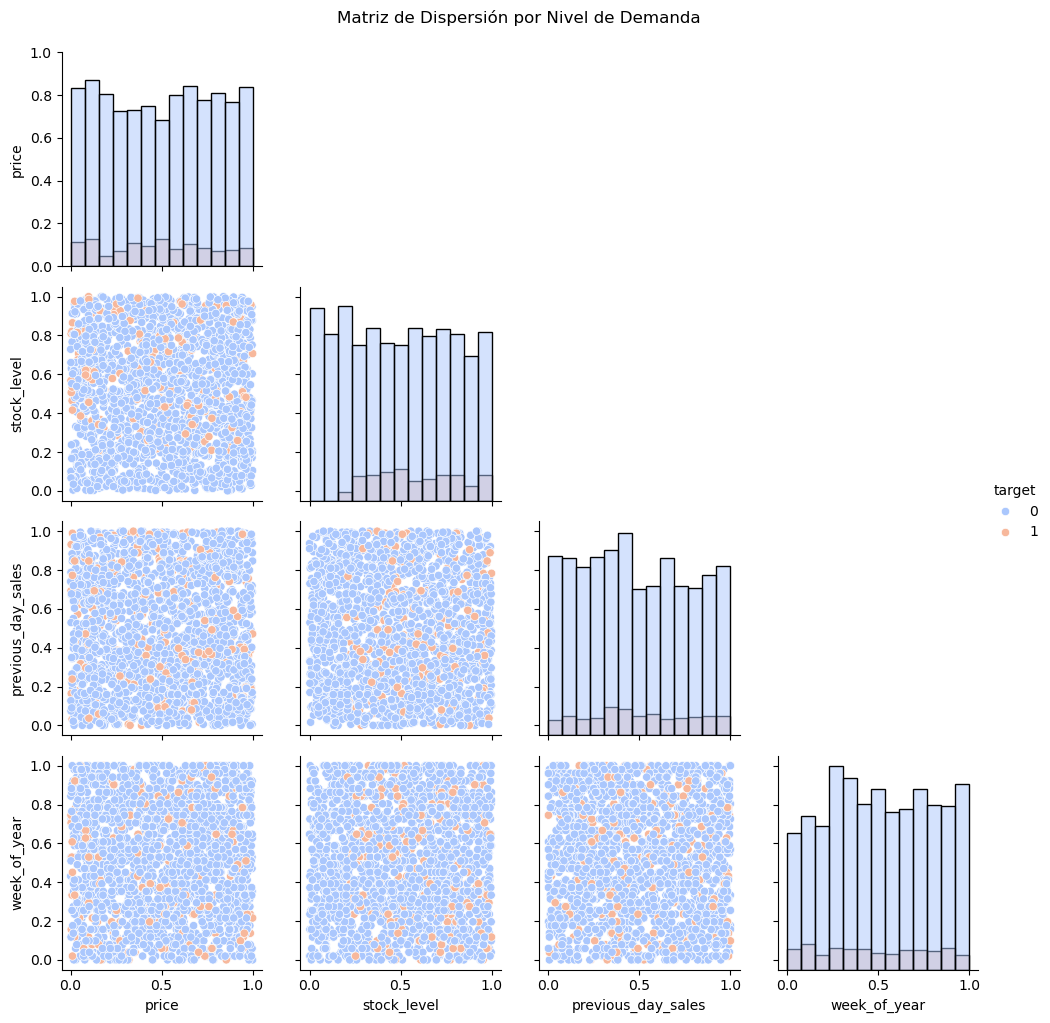

In [190]:
# Matriz de Dispersión por Nivel de Demanda 

# Definir las columnas numéricas que se usarán en la matriz de dispersión
subset_cols = ['price', 'stock_level', 'previous_day_sales', 'week_of_year']

# Crear un PairGrid de seaborn con las variables seleccionadas y asignar color para 'target'
g = sns.PairGrid(data=data, vars=subset_cols, hue='target', palette='coolwarm')

# Graficar diagramas de dispersión solo en la mitad inferior de la matriz para evitar duplicados
g.map_lower(sns.scatterplot)

# Graficar histogramas en la diagonal para mostrar la distribución de cada variable
g.map_diag(sns.histplot, kde=False)

# Ocultar los gráficos en la mitad superior de la matriz para dejar esos espacios en blanco
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

# Añadir la leyenda para identificar las clases de la variable objetivo
g.add_legend()

# Agregar un título general al gráfico con un pequeño ajuste en la posición vertical
plt.suptitle('Matriz de Dispersión por Nivel de Demanda', y=1.02)

# Mostrar el gráfico
plt.show()

### ¿Qué nos dice esta matriz de dispersión sobre la demanda?

**1. Cantidad de casos de cada tipo:**

* Hay muchos más casos donde la demanda fue baja (puntos azules) que donde fue alta (puntos naranjas).
* Esto significa que la demanda alta pasa menos seguido (demostrado en el desbalance de clases).

**2. Variables que más ayudan a diferenciar entre demanda alta y baja:**

* **Precio:** Cuando el precio es bajo, es más probable que la demanda sea alta. Los puntos naranjas están más hacia precios bajos.
* **Ventas del día anterior:** Si se vendieron muchas unidades el día anterior, es muy probable que también la demanda sea alta hoy. Esto muestra que la demanda sigue una tendencia.

**3. Variables con un efecto menos claro:**

* **Nivel de inventario:** Tener más stock parece ayudar a que la demanda sea alta, pero no es tan evidente.
* **Semana del año:** Algunas semanas tienen más demanda alta que otras, lo que indica que hay patrones durante el año.

**4. Variables que no se ven tan importantes en este gráfico:**

* Cosas como descuentos, promociones o el clima no muestran un impacto significativo, por eso no se incluyen aquí.


### ¿Qué significa esto para el negocio?

* **Precio:** Ofrecer precios competitivos puede ayudar a vender más.
* **Ventas anteriores:** Las ventas recientes son un buen indicador para saber si la demanda va a ser alta.
* **Inventario:** Es importante tener suficiente stock para aprovechar la demanda alta.
* **Estacionalidad:** Hay que prestar atención a las semanas del año para planear mejor.

Este gráfico nos ayuda a ver qué cosas influyen más para predecir cuándo habrá mucha demanda y nos dice que el precio y las ventas del día anterior son las variables más importantes para tener en cuenta.


# 3. Entrenamiento y Evaluación de Modelos de Clasificación

## 3.1 Separación de características y variable objetivo

Separamos la variable `target` (demanda alta o baja) del resto de las características predictoras.

In [191]:
# Separar características y variable objetivo
X = data.drop('target', axis=1)
y = data['target']

## 3.2 División del conjunto de datos
Utilizamos `train_test_split` para dividir los datos en un conjunto de entrenamiento (75%) y uno de prueba (25%), manteniendo la proporción de clases mediante la opción `stratify`.

In [192]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

## 3.3 Balanceo de clases con SMOTE
Como los datos presentan un desbalance de clases, aplicamos la técnica SMOTE (Synthetic Minority Oversampling Technique) para generar instancias sintéticas de la clase minoritaria en el conjunto de entrenamiento.

In [193]:
# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## 3.4 Entrenamiento de modelos
Se entrenan dos modelos de clasificación:    
**Regresión Logística y Random Forest**.     
Cada modelo se ajusta con los datos remuestreados, y luego se evalúa en el conjunto de prueba utilizando  **Classification Report** y la métrica de evaluación **Confusion Matrix**.

**Evaluación de Modelos**      

Los modelos serán evaluados con dos métricas claves **F1-score y Matriz de Confusión**

F1-score: es una métrica que combina la precisión y el recall en un solo número, proporcionando un balance entre ambos. Es especialmente útil cuando las clases están desbalanceadas, porque me ayuda a saber si el modelo predice bien tanto la demanda alta como la baja. Un f1-score más cercano a 1 indica mejor desempeño.

Matriz de Confusión: mostrado en un gráfico, esta tabla expone la cantidad de predicciones correctas e incorrectas para cada clase. Aquí puedo ver cuántas veces el modelo clasificó bien la demanda alta y baja, así como los errores que cometió (falsos positivos y falsos negativos). Esto ayuda a entender si el modelo tiende a equivocarse más con una clase que con otra.


Model: Logistic Regression
F1 Score Class 0: 0.9853
F1 Score Class 1: 0.8870


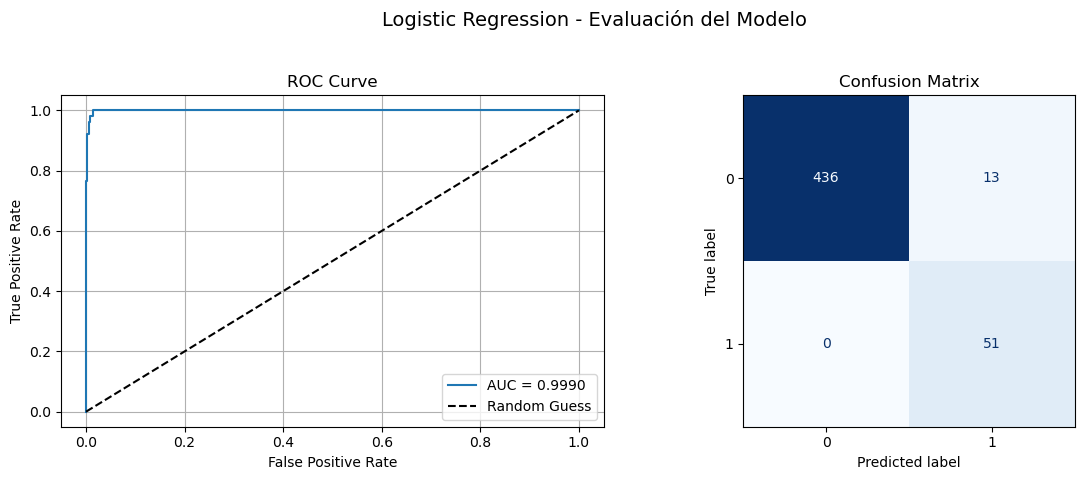


Model: Random Forest
F1 Score Class 0: 1.0000
F1 Score Class 1: 1.0000


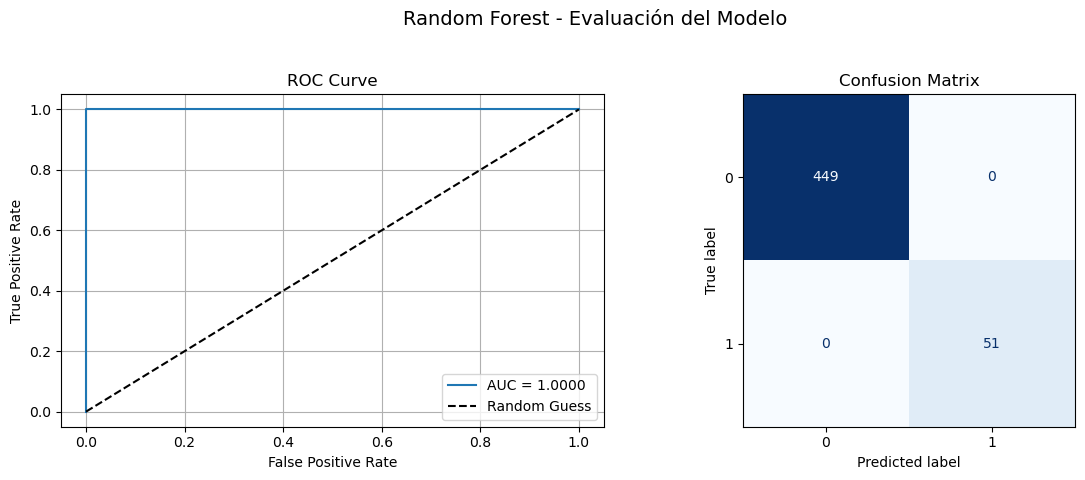

In [194]:
# Definir los modelos a entrenar
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Iterar sobre cada modelo
for name, model in models.items():
    # Entrenar el modelo con los datos balanceados
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predicciones
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # F1 Scores
    f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
    f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
    
    print(f"\nModel: {name}")
    print(f"F1 Score Class 0: {f1_class_0:.4f}")
    print(f"F1 Score Class 1: {f1_class_1:.4f}")
    
    # Crear una figura con dos subplots lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'{name} - Evaluación del Modelo', fontsize=14)

    # Subplot 1: Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random Guess')
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend(loc='lower right')
    axes[0].grid(True)

    # Subplot 2: Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False)
    axes[1].set_title('Confusion Matrix')
    axes[1].grid(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

**Logistic Regression:**
El modelo muestra muy buena precisión y recall, logrando detectar todos los casos de alta demanda (clase 1) sin errores. Sin embargo, presenta algunos fallos en la clase baja, con 13 casos mal clasificados. En general, su rendimiento es excelente, con un AUC cercano a 1 (0.999), lo que indica una capacidad casi perfecta para distinguir entre ambas clases.

**Random Forest:**

El modelo logró resultados perfectos, sin ninguna clasificación errónea. Tanto en **accuracy** como el AUC alcanzaron un 100%, demostrando un desempeño ideal y una capacidad total para distinguir correctamente entre las clases del target.


## 3.5 Validación cruzada

La validación cruzada se utiliza para confirmar que los resultados tan precisos de los modelos no se deban simplemente a cómo se dividieron los datos inicialmente. Así verifico que el modelo realmente generaliza correctamente los datos.

In [195]:
# Validación cruzada con AUC-ROC para Logistic Regression y Random Forest
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

print("Validación Cruzada:")
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    print(f"{name} AUC-ROC promedio: {scores.mean():.4f} ± {scores.std():.4f}")

# Entrenar y evaluar modelo Dummy (baseline)
dummy = DummyClassifier(strategy="most_frequent")
dummy_scores = cross_val_score(dummy, X, y, cv=cv, scoring='roc_auc')
print(f"\nDummy Classifier AUC-ROC promedio: {dummy_scores.mean():.4f} ± {dummy_scores.std():.4f}")


Validación Cruzada:
Logistic Regression AUC-ROC promedio: 0.9996 ± 0.0003
Random Forest AUC-ROC promedio: 1.0000 ± 0.0000

Dummy Classifier AUC-ROC promedio: 0.5000 ± 0.0000


**Análisis de los Resultados**

**Logistic Regression y Random Forest tienen un AUC-ROC casi perfecto (0.9996 y 1.0)**. Esto indica que el modelo es consistente y muy bueno para separar las clases.

**Dummy Classifier tiene un AUC de 0.5**, que es el valor esperado para un clasificador que predice siempre la clase mayoritaria (o al azar). Esto confirma que los modelos están aprendiendo patrones reales.

**Los datos y la división parecen estar bien, no hay indicios claros de problemas como filtración de datos o separación incorrecta**. El modelo Random Forest tiene un desempeño excelente y confiable para este problema.

# 4.  Conlusiones
**Mejor modelo:**     
**Random Forest** es el mejor modelo de los dos, con clasificación perfecta. Logistic Regression también funciona muy bien, pero tiene unos pocos errores en la clase baja.

Ya que Random Forest ofrece resultados óptimos, no es necesario usar modelos más complejos como CatBoost o LightGBM, que están diseñados para manejar datasets más difíciles, con características más complejas o para obtener mejoras cuando los modelos más simples no alcanzan buen desempeño.

Además, el uso de técnicas de balanceo como SMOTE fue clave para mejorar el desempeño del modelo en un conjunto de datos con clases desbalanceadas. Esto permitió que ambos modelos aprendieran a reconocer correctamente tanto la demanda alta como la baja, mejorando así los valores de F1 Score y la curva AUC-ROC.